In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Any
import warnings
import os
from glob import glob
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
warnings.filterwarnings('ignore')
os.chdir('../../../hw3')

/Users/jarvis/opt/anaconda3/envs/cs285/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Helper Functions

In [3]:
def load_run_metric(logdir_name, iterations=1):

    # source: https://tbparse.readthedocs.io/en/latest/pages/raw.html#event-accumulator
    data_path = os.path.join(os.getcwd(), 'data')
    logdir = os.path.join(data_path, logdir_name)
    logfile = os.path.join(logdir, 'events*')
    logfile = glob(logfile)[0]
    metrics = {}
    
    event_acc = EventAccumulator(logfile)
    event_acc.Reload()

    if iterations == 1:
        for metric in event_acc.Tags()['scalars']:
            metrics[metric] = event_acc.Scalars(metric)[0].value
    else:
        for iter in np.arange(iterations):
            metrics[iter] = {}

            if iter == 0:
                for metric in event_acc.Tags()['scalars']:
                    metrics[iter][metric] = event_acc.Scalars(metric)[iter].value
            else:
                for metric in event_acc.Tags()['scalars'][:-1]:
                    metrics[iter][metric] = event_acc.Scalars(metric)[iter].value
                
    return metrics

In [4]:
def extract_tensorboard_scalars(log_file, scalar_keys):
    # Initialize an EventAccumulator with the path to the log directory
    event_acc = EventAccumulator(log_file)
    event_acc.Reload()  # Load the events from disk

    if isinstance(scalar_keys, str):
        scalar_keys = [scalar_keys]

    # Extract the scalar summaries
    scalars = {}
    for tag in scalar_keys:
        scalars_for_tag = event_acc.Scalars(tag)
        scalars[tag] = {
            'step': [s.step for s in scalars_for_tag],
            'wall_time': [s.wall_time for s in scalars_for_tag],
            'value': [s.value for s in scalars_for_tag],
        }

    return scalars

In [5]:
def compute_mean_std(scalars: List[Dict[str, Any]],
                     data_key: str,
                     ninterp=100):
    min_step = min([s for slog in scalars for s in slog[data_key]['step']])
    max_step = max([s for slog in scalars for s in slog[data_key]['step']])
    steps = np.linspace(min_step, max_step, ninterp)
    scalars_interp = np.stack([
        np.interp(steps, slog[data_key]['step'], slog[data_key]['value'], left=float('nan'), right=float('nan'))
        for slog in scalars
    ], axis=1)

    mean = np.mean(scalars_interp, axis=1)
    std = np.std(scalars_interp, axis=1)

    return steps, mean, std

## 2 Deep Q-Learning

### 2.4 Basic Q-Learning

CartPole-v1

- Command to run: 

`python cs285/scripts/run_hw3_dqn.py -cfg experiments/dqn/cartpole.yaml --seed 1`

In [8]:
cartpole_metrics = extract_tensorboard_scalars('./data/hw3_dqn_dqn_CartPole-v1_s64_l2_d0.99_15-10-2023_12-46-26/', scalar_keys='eval_return')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


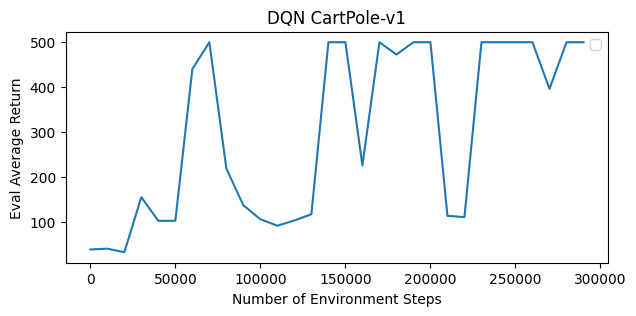

In [9]:
# plot

plt.figure(figsize=(7, 3))
plt.plot(cartpole_metrics['eval_return']['step'], cartpole_metrics['eval_return']['value'])

plt.title('DQN CartPole-v1')
plt.xlabel('Number of Environment Steps')
plt.ylabel('Eval Average Return')
plt.legend()
plt.show()

LunarLander-v2

- Command to run:

`python cs285/scripts/run_hw3_dqn.py -cfg experiments/dqn/lunarlander.yaml --seed 1`\
`python cs285/scripts/run_hw3_dqn.py -cfg experiments/dqn/lunarlander.yaml --seed 2`\
`python cs285/scripts/run_hw3_dqn.py -cfg experiments/dqn/lunarlander.yaml --seed 3`

In [6]:
lunarlander_seed1 = extract_tensorboard_scalars('./data/hw3_dqn_dqn_LunarLander-v2_s64_l2_d0.99_16-10-2023_12-46-58/', scalar_keys='eval_return')
lunarlander_seed2 = extract_tensorboard_scalars('./data/hw3_dqn_dqn_LunarLander-v2_s64_l2_d0.99_16-10-2023_12-47-39/', scalar_keys='eval_return')
lunarlander_seed3 = extract_tensorboard_scalars('./data/hw3_dqn_dqn_LunarLander-v2_s64_l2_d0.99_16-10-2023_12-47-45/', scalar_keys='eval_return')

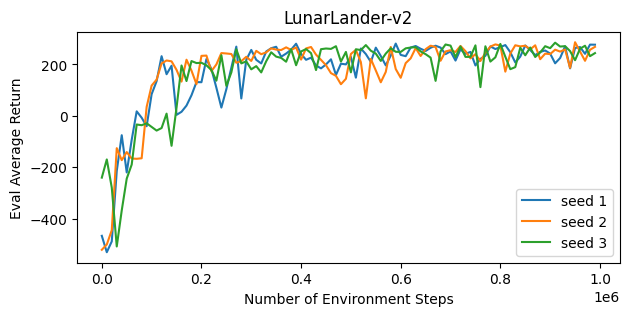

In [107]:
# plot

plt.figure(figsize=(7, 3))
plt.plot(lunarlander_seed1['eval_return']['step'], lunarlander_seed1['eval_return']['value'], label='seed 1')
plt.plot(lunarlander_seed2['eval_return']['step'], lunarlander_seed2['eval_return']['value'], label='seed 2')
plt.plot(lunarlander_seed3['eval_return']['step'], lunarlander_seed3['eval_return']['value'], label='seed 3')

plt.title('LunarLander-v2')
plt.xlabel('Number of Environment Steps')
plt.ylabel('Eval Average Return')
plt.legend()
plt.show()

CartPole-v1, learning_rate = 0.05

- Command to run:

`python cs285/scripts/run_hw3_dqn.py -cfg experiments/dqn/cartpole_lr_5e-2.yaml`

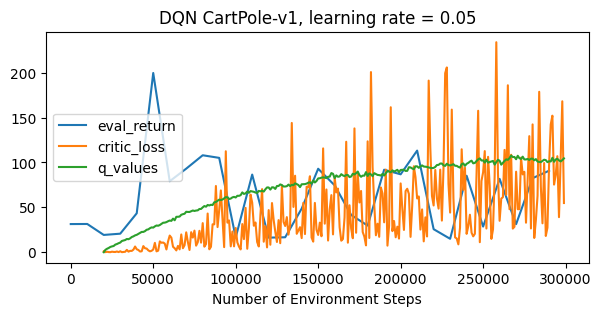

In [12]:
run_name = './data/hw3_dqn_dqn_CartPole-v1_s64_l2_d0.99_15-10-2023_12-21-26/'

plt.figure(figsize=(7, 3))
plt.plot(
    extract_tensorboard_scalars(run_name, 'eval_return')['eval_return']['step'], 
    extract_tensorboard_scalars(run_name, 'eval_return')['eval_return']['value'],
    label='eval_return')

plt.plot(
    extract_tensorboard_scalars(run_name, 'critic_loss')['critic_loss']['step'], 
    extract_tensorboard_scalars(run_name, 'critic_loss')['critic_loss']['value'],
    label='critic_loss')

plt.plot(
    extract_tensorboard_scalars(run_name, 'q_values')['q_values']['step'], 
    extract_tensorboard_scalars(run_name, 'q_values')['q_values']['value'],
    label='q_values')

plt.title('DQN CartPole-v1, learning rate = 0.05')
plt.xlabel('Number of Environment Steps')
# plt.ylabel('Eval Average Return')
plt.legend()
plt.show()

### 2.5 Double Q-Learning

- Command to run:

`python cs285/scripts/run_hw3_dqn.py -cfg experiments/dqn/lunarlander_doubleq.yaml --seed 1`\
`python cs285/scripts/run_hw3_dqn.py -cfg experiments/dqn/lunarlander_doubleq.yaml --seed 2`\
`python cs285/scripts/run_hw3_dqn.py -cfg experiments/dqn/lunarlander_doubleq.yaml --seed 3`

In [20]:
# 1q
lunarlander_xs, lunarlander_mean, lunarlander_std = compute_mean_std([
    lunarlander_seed1, lunarlander_seed2, lunarlander_seed3
], 'eval_return')

lunarlander_seed1 = extract_tensorboard_scalars('./data/hw3_dqn_dqn_LunarLander-v2_s64_l2_d0.99_16-10-2023_12-46-58/', scalar_keys='q_values')
lunarlander_seed2 = extract_tensorboard_scalars('./data/hw3_dqn_dqn_LunarLander-v2_s64_l2_d0.99_16-10-2023_12-47-39/', scalar_keys='q_values')
lunarlander_seed3 = extract_tensorboard_scalars('./data/hw3_dqn_dqn_LunarLander-v2_s64_l2_d0.99_16-10-2023_12-47-45/', scalar_keys='q_values')

lunarlander_q_xs, lunarlander_q_mean, lunarlander_q_std = compute_mean_std([
    lunarlander_seed1, lunarlander_seed2, lunarlander_seed3
], 'q_values')

In [21]:
# double q

lunarlander_doubledqn_seed1 = extract_tensorboard_scalars('./data/hw3_dqn_dqn_LunarLander-v2_s64_l2_d0.99_doubleq_16-10-2023_12-46-28/', scalar_keys='eval_return')
lunarlander_doubledqn_seed2 = extract_tensorboard_scalars('./data/hw3_dqn_dqn_LunarLander-v2_s64_l2_d0.99_doubleq_16-10-2023_12-46-32/', scalar_keys='eval_return')
lunarlander_doubledqn_seed3 = extract_tensorboard_scalars('./data/hw3_dqn_dqn_LunarLander-v2_s64_l2_d0.99_doubleq_16-10-2023_12-46-36/', scalar_keys='eval_return')

lunarlander_doubledqn_xs, lunarlander_doubledqn_mean, lunarlander_doubledqn_std = compute_mean_std([
    lunarlander_doubledqn_seed1, lunarlander_doubledqn_seed2, lunarlander_doubledqn_seed3
], 'eval_return')

lunarlander_doubledqn_seed1 = extract_tensorboard_scalars('./data/hw3_dqn_dqn_LunarLander-v2_s64_l2_d0.99_doubleq_16-10-2023_12-46-28/', scalar_keys='q_values')
lunarlander_doubledqn_seed2 = extract_tensorboard_scalars('./data/hw3_dqn_dqn_LunarLander-v2_s64_l2_d0.99_doubleq_16-10-2023_12-46-32/', scalar_keys='q_values')
lunarlander_doubledqn_seed3 = extract_tensorboard_scalars('./data/hw3_dqn_dqn_LunarLander-v2_s64_l2_d0.99_doubleq_16-10-2023_12-46-36/', scalar_keys='q_values')

lunarlander_doubledqn_q_xs, lunarlander_doubledqn_q_mean, lunarlander_doubledqn_q_std = compute_mean_std([
    lunarlander_doubledqn_seed1, lunarlander_doubledqn_seed2, lunarlander_doubledqn_seed3
], 'q_values')

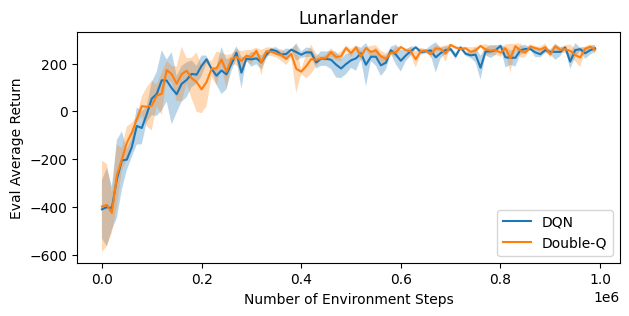

In [18]:
plt.figure(figsize=(7, 3))
plt.plot(lunarlander_xs, lunarlander_mean, label='DQN')
plt.fill_between(lunarlander_xs, lunarlander_mean-lunarlander_std, lunarlander_mean+lunarlander_std, alpha=0.3)
plt.plot(lunarlander_doubledqn_xs, lunarlander_doubledqn_mean, label='Double-Q')
plt.fill_between(lunarlander_doubledqn_xs, lunarlander_doubledqn_mean-lunarlander_doubledqn_std, lunarlander_doubledqn_mean+lunarlander_doubledqn_std, alpha=0.3)
plt.legend()
plt.title('Lunarlander')
plt.xlabel('Number of Environment Steps')
plt.ylabel('Eval Average Return')
plt.legend()
plt.show()

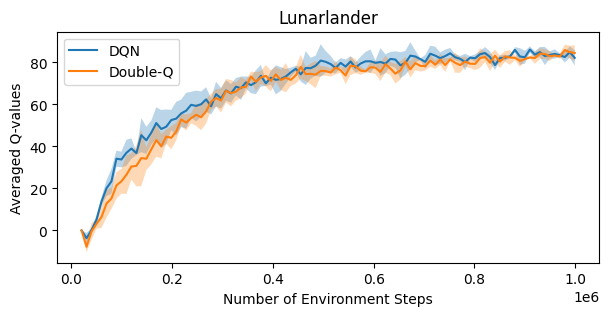

In [22]:
plt.figure(figsize=(7, 3))
plt.plot(lunarlander_q_xs, lunarlander_q_mean, label='DQN')
plt.fill_between(lunarlander_q_xs, lunarlander_q_mean-lunarlander_q_std, lunarlander_q_mean+lunarlander_q_std, alpha=0.3)
plt.plot(lunarlander_doubledqn_q_xs, lunarlander_doubledqn_q_mean, label='Double-Q')
plt.fill_between(lunarlander_doubledqn_q_xs, lunarlander_doubledqn_q_mean-lunarlander_doubledqn_q_std, lunarlander_doubledqn_q_mean+lunarlander_doubledqn_q_std, alpha=0.3)
plt.legend()
plt.title('Lunarlander')
plt.xlabel('Number of Environment Steps')
plt.ylabel('Averaged Q-values')
plt.legend()
plt.show()

MsPacman-v0

- Command to run:

`python cs285/scripts/run_hw3_dqn.py -cfg experiments/dqn/mspacman.yaml`

In [83]:
mspacman_eval = extract_tensorboard_scalars('./data/hw3_dqn_dqn_MsPacmanNoFrameskip-v0_d0.99_tu2000_lr0.0001_doubleq_clip10.0_15-10-2023_15-15-40/', scalar_keys='eval_return')
mspacman_train = extract_tensorboard_scalars('./data/hw3_dqn_dqn_MsPacmanNoFrameskip-v0_d0.99_tu2000_lr0.0001_doubleq_clip10.0_15-10-2023_15-15-40/', scalar_keys='train_return')

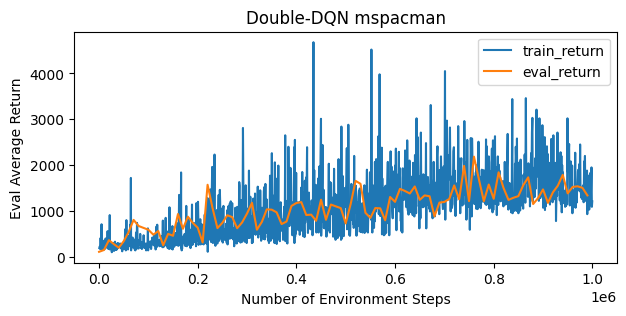

In [84]:
# plot

plt.figure(figsize=(7, 3))
plt.plot(mspacman_train['train_return']['step'], mspacman_train['train_return']['value'], label='train_return')
plt.plot(mspacman_eval['eval_return']['step'], mspacman_eval['eval_return']['value'], label='eval_return')

plt.title('Double-DQN mspacman')
plt.xlabel('Number of Environment Steps')
plt.ylabel('Eval Average Return')
plt.legend()
plt.show()

### 2.6 Experimenting with Hyperparameters

Experimenting with three different `learning_rate` values on CartPole-v1

- `learning_rate = 5e-3`
- `learning_rate = 5e-4`
- `learning_rate = 1e-4`

The default `learning_rate = 1e-3`

- Command to run:

`python cs285/scripts/run_hw3_dqn.py -cfg experiments/dqn/cartpole_lr_1e-4.yaml`\
`python cs285/scripts/run_hw3_dqn.py -cfg experiments/dqn/cartpole_lr_5e-3.yaml`\
`python cs285/scripts/run_hw3_dqn.py -cfg experiments/dqn/cartpole_lr_5e-4.yaml`

In [31]:
cartpole_lr5e_2 = extract_tensorboard_scalars('./data/hw3_dqn_dqn_CartPole-v1_s64_l2_d0.99_15-10-2023_12-21-26/', scalar_keys='eval_return')
cartpole_lr5e_3 = extract_tensorboard_scalars('./data/hw3_dqn_dqn_CartPole-v1_s64_l2_d0.99_15-10-2023_16-05-29/', scalar_keys='eval_return')
cartpole_lr5e_4 = extract_tensorboard_scalars('./data/hw3_dqn_dqn_CartPole-v1_s64_l2_d0.99_15-10-2023_16-05-53/', scalar_keys='eval_return')
cartpole_lr1e_4 = extract_tensorboard_scalars('./data/hw3_dqn_dqn_CartPole-v1_s64_l2_d0.99_15-10-2023_16-06-12/', scalar_keys='eval_return')

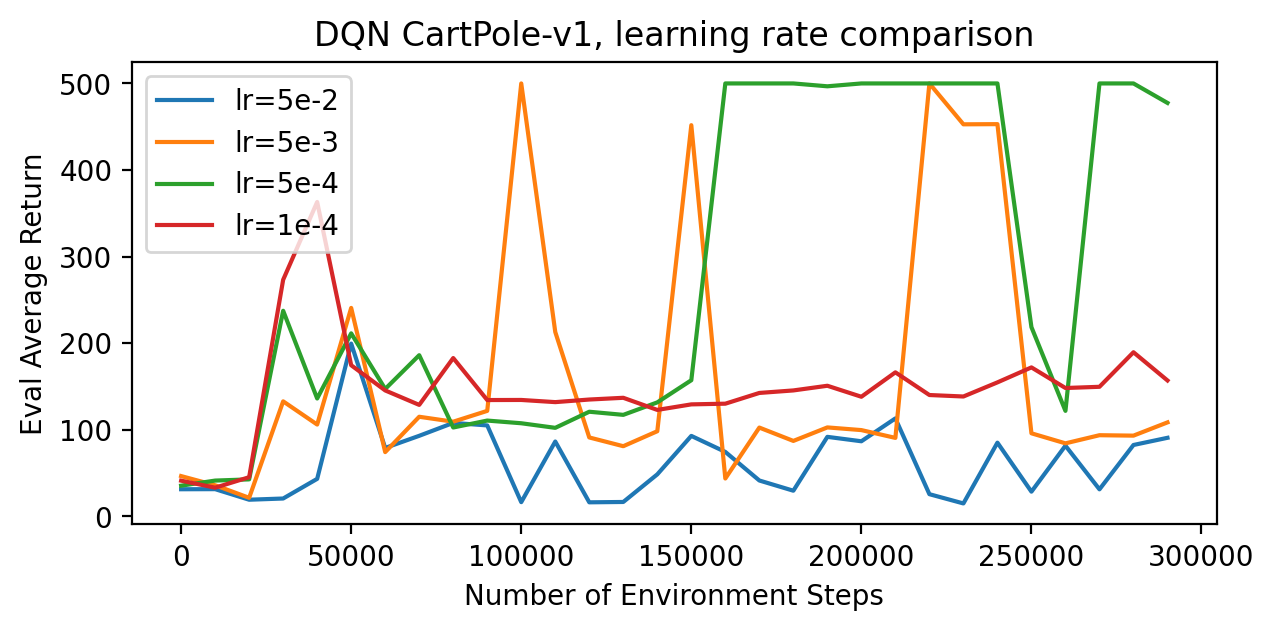

In [35]:
# plot

plt.figure(figsize=(7, 3), dpi=200)
plt.plot(cartpole_lr5e_2['eval_return']['step'], cartpole_lr5e_2['eval_return']['value'], label='lr=5e-2')
plt.plot(cartpole_lr5e_3['eval_return']['step'], cartpole_lr5e_3['eval_return']['value'], label='lr=5e-3')
plt.plot(cartpole_lr5e_4['eval_return']['step'], cartpole_lr5e_4['eval_return']['value'], label='lr=5e-4')
plt.plot(cartpole_lr1e_4['eval_return']['step'], cartpole_lr1e_4['eval_return']['value'], label='lr=1e-4')

plt.title('DQN CartPole-v1, learning rate comparison')
plt.xlabel('Number of Environment Steps')
plt.ylabel('Eval Average Return')
plt.legend()
plt.show()

## 3 Continuous Actions with Actor-Critic

### 3.1.1 Bootstrapping

Command to run:

`python cs285/scripts/run_hw3_sac.py -cfg experiments/sac/sanity_pendulum.yaml`

In [36]:
pendulum_bootstrap = extract_tensorboard_scalars('./data/hw3_sac_sanity_pendulum_Pendulum-v1_reinforce_s128_l3_alr0.0003_clr0.0003_b128_d0.99_t0.1_htu1000_16-10-2023_01-29-17/', scalar_keys='q_values')

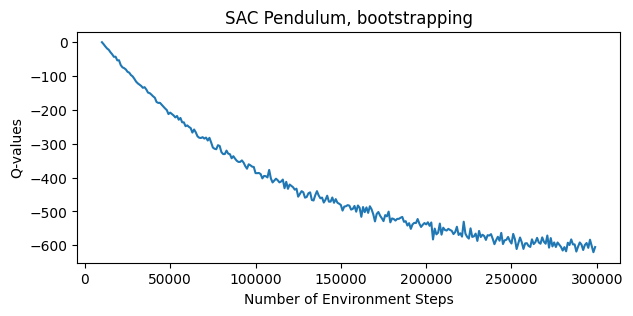

In [38]:
# plot

plt.figure(figsize=(7, 3))
plt.plot(pendulum_bootstrap['q_values']['step'], pendulum_bootstrap['q_values']['value'])

plt.title('SAC Pendulum, bootstrapping')
plt.xlabel('Number of Environment Steps')
plt.ylabel('Q-values')
# plt.legend()
plt.show()

### 3.1.2 Entropy Bonus and Soft Actor-Critic

Command to run:

`python cs285/scripts/run_hw3_sac.py -cfg experiments/sac/sanity_pendulum.yaml`

### 3.1.3 Actor with REINFORCE

Command to run:

`python cs285/scripts/run_hw3_sac.py -cfg experiments/sac/sanity_invertedpendulum_reinforce.yaml`

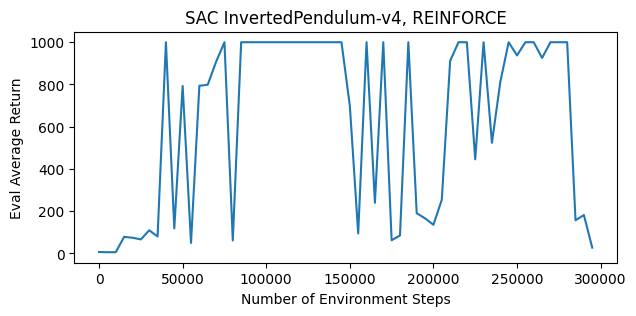

In [82]:
# sanity_invertedpendulum_reinforce.yaml

invertedpendulum = extract_tensorboard_scalars('./data/hw3_sac_sanity_invpendulum_reinforce_InvertedPendulum-v4_reinforce_s128_l3_alr0.0003_clr0.0003_b128_d0.99_t0.1_htu1000_16-10-2023_02-51-46/', scalar_keys='eval_return')
plt.figure(figsize=(7, 3))
plt.plot(invertedpendulum['eval_return']['step'], invertedpendulum['eval_return']['value'])

plt.title('SAC InvertedPendulum-v4, REINFORCE')
plt.xlabel('Number of Environment Steps')
plt.ylabel('Eval Average Return')
plt.show()

HalfCheetah-v4

Command to run: 

`python cs285/scripts/run_hw3_sac.py -cfg experiments/sac/halfcheetah_reinforce1.yaml`\
`python cs285/scripts/run_hw3_sac.py -cfg experiments/sac/halfcheetah_reinforce10.yaml`

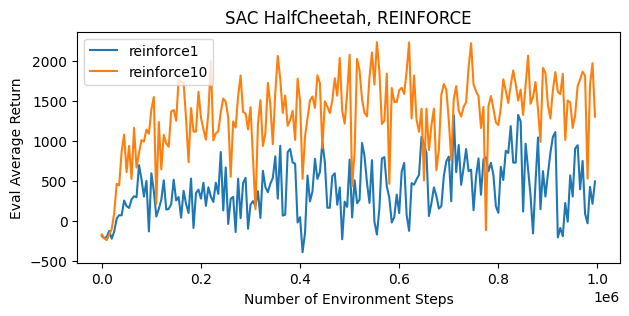

In [77]:
halfcheetah_reinforce1 = extract_tensorboard_scalars('./data/hw3_sac_reinforce1_HalfCheetah-v4_reinforce_s128_l3_alr0.0003_clr0.0003_b128_d0.99_t0.2_stu0.005_16-10-2023_02-55-43/', scalar_keys='eval_return')
halfcheetah_reinforce10 = extract_tensorboard_scalars('./data/hw3_sac_reinforce10_HalfCheetah-v4_reinforce_s128_l3_alr0.0003_clr0.0003_b128_d0.99_t0.2_stu0.005_16-10-2023_02-57-19/', scalar_keys='eval_return')

# plot

plt.figure(figsize=(7, 3))
plt.plot(halfcheetah_reinforce1['eval_return']['step'], halfcheetah_reinforce1['eval_return']['value'], label='reinforce1')
plt.plot(halfcheetah_reinforce10['eval_return']['step'], halfcheetah_reinforce10['eval_return']['value'], label='reinforce10')

plt.title('SAC HalfCheetah, REINFORCE')
plt.xlabel('Number of Environment Steps')
plt.ylabel('Eval Average Return')
plt.legend()
plt.show()

### 3.1.4 Actor with REPARAMETRIZE

Command to run:

`python cs285/scripts/run_hw3_sac.py -cfg experiments/sac/halfcheetah_reparametrize.yaml`

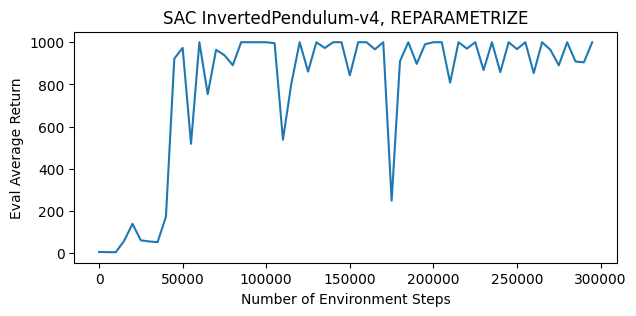

In [78]:
# sanity_invertedpendulum_reparametrize.yaml

invertedpendulum = extract_tensorboard_scalars('./data/hw3_sac_sanity_invpendulum_reparametrize_InvertedPendulum-v4_reparametrize_s128_l3_alr0.0003_clr0.0003_b128_d0.99_t0.1_htu1000_16-10-2023_03-03-51/', scalar_keys='eval_return')
plt.figure(figsize=(7, 3))
plt.plot(invertedpendulum['eval_return']['step'], invertedpendulum['eval_return']['value'])

plt.title('SAC InvertedPendulum-v4, REPARAMETRIZE')
plt.xlabel('Number of Environment Steps')
plt.ylabel('Eval Average Return')
plt.show()

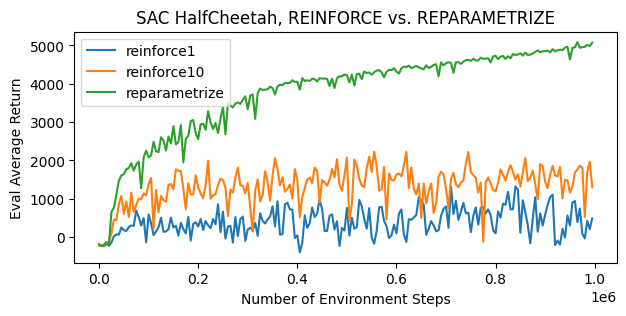

In [79]:
halfcheetah_repm = extract_tensorboard_scalars('./data/hw3_sac_reparametrize_HalfCheetah-v4_reparametrize_s128_l3_alr0.0003_clr0.0003_b128_d0.99_t0.1_stu0.005_16-10-2023_03-04-17/', scalar_keys='eval_return')

# plot

plt.figure(figsize=(7, 3))
plt.plot(halfcheetah_reinforce1['eval_return']['step'], halfcheetah_reinforce1['eval_return']['value'], label='reinforce1')
plt.plot(halfcheetah_reinforce10['eval_return']['step'], halfcheetah_reinforce10['eval_return']['value'], label='reinforce10')
plt.plot(halfcheetah_repm['eval_return']['step'], halfcheetah_repm['eval_return']['value'], label='reparametrize')

plt.title('SAC HalfCheetah, REINFORCE vs. REPARAMETRIZE')
plt.xlabel('Number of Environment Steps')
plt.ylabel('Eval Average Return')
plt.legend()
plt.show()

Humanoid-v4, 1q, REPARAMETRIZE

Command to run:

`python cs285/scripts/run_hw3_sac.py -cfg experiments/sac/humanoid_1q_reparametrize.yaml`

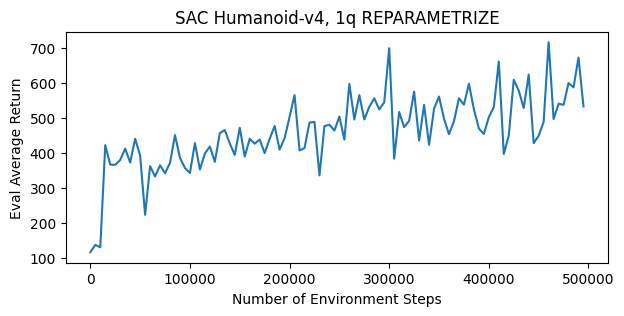

In [125]:
# humanoid.yaml with 1q REPARAMETRIZE

humanoid_sac = extract_tensorboard_scalars('./data/hw3_sac_sac_humanoid_1q_Humanoid-v4_reparametrize_s256_l3_alr0.0003_clr0.0003_b256_d0.99_t0.05_stu0.005_16-10-2023_14-40-01/', scalar_keys='eval_return')
plt.figure(figsize=(7, 3))
plt.plot(humanoid_sac['eval_return']['step'], humanoid_sac['eval_return']['value'])

plt.title('SAC Humanoid-v4, 1q REPARAMETRIZE')
plt.xlabel('Number of Environment Steps')
plt.ylabel('Eval Average Return')
plt.show()

### 3.1.5 Stabilizing Target Values

Command to run:

`python cs285/scripts/run_hw3_sac.py -cfg experiments/sac/hopper.yaml`\
`python cs285/scripts/run_hw3_sac.py -cfg experiments/sac/hopper_doubleq.yaml`\
`python cs285/scripts/run_hw3_sac.py -cfg experiments/sac/hopper_clipq.yaml`

In [110]:
hopper_single_q_eval = extract_tensorboard_scalars('./data/hw3_sac_sac_hopper_singlecritic_Hopper-v4_reparametrize_s128_l3_alr0.0003_clr0.0003_b256_d0.99_t0.05_stu0.005_16-10-2023_11-14-45/', scalar_keys='eval_return')
hopper_double_q_eval = extract_tensorboard_scalars('./data/hw3_sac_sac_hopper_doubleq_Hopper-v4_reparametrize_s128_l3_alr0.0003_clr0.0003_b256_d0.99_t0.05_stu0.005_doubleq_16-10-2023_11-14-50/', scalar_keys='eval_return')
hopper_clipped_q_eval = extract_tensorboard_scalars('./data/hw3_sac_sac_hopper_clipq_Hopper-v4_reparametrize_s128_l3_alr0.0003_clr0.0003_b256_d0.99_t0.05_stu0.005_min_16-10-2023_11-14-55/', scalar_keys='eval_return')

hopper_single_q_qval = extract_tensorboard_scalars('./data/hw3_sac_sac_hopper_singlecritic_Hopper-v4_reparametrize_s128_l3_alr0.0003_clr0.0003_b256_d0.99_t0.05_stu0.005_16-10-2023_11-14-45/', scalar_keys='q_values')
hopper_double_q_qval = extract_tensorboard_scalars('./data/hw3_sac_sac_hopper_doubleq_Hopper-v4_reparametrize_s128_l3_alr0.0003_clr0.0003_b256_d0.99_t0.05_stu0.005_doubleq_16-10-2023_11-14-50/', scalar_keys='q_values')
hopper_clipped_q_qval = extract_tensorboard_scalars('./data/hw3_sac_sac_hopper_clipq_Hopper-v4_reparametrize_s128_l3_alr0.0003_clr0.0003_b256_d0.99_t0.05_stu0.005_min_16-10-2023_11-14-55/', scalar_keys='q_values')

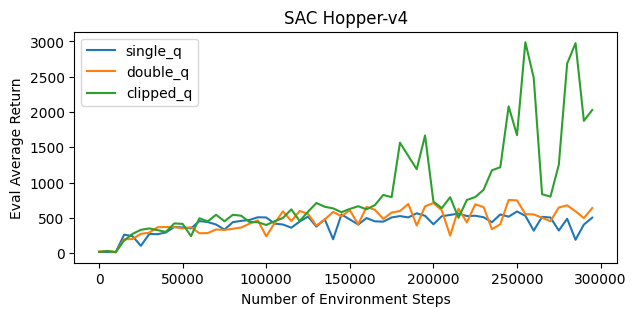

In [111]:
plt.figure(figsize=(7, 3))
plt.plot(hopper_single_q_eval['eval_return']['step'], hopper_single_q_eval['eval_return']['value'], label='single_q')
plt.plot(hopper_double_q_eval['eval_return']['step'], hopper_double_q_eval['eval_return']['value'], label= 'double_q')
plt.plot(hopper_clipped_q_eval['eval_return']['step'], hopper_clipped_q_eval['eval_return']['value'], label='clipped_q')

plt.title('SAC Hopper-v4')
plt.xlabel('Number of Environment Steps')
plt.ylabel('Eval Average Return')
plt.legend()
plt.show()

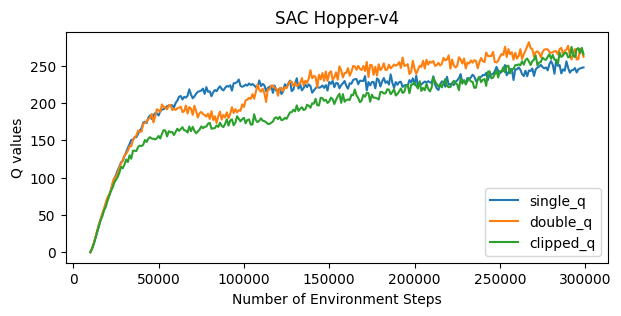

In [113]:
plt.figure(figsize=(7, 3))
plt.plot(hopper_single_q_qval['q_values']['step'], hopper_single_q_qval['q_values']['value'], label='single_q')
plt.plot(hopper_double_q_qval['q_values']['step'], hopper_double_q_qval['q_values']['value'], label= 'double_q')
plt.plot(hopper_clipped_q_qval['q_values']['step'], hopper_clipped_q_qval['q_values']['value'], label='clipped_q')

plt.title('SAC Hopper-v4')
plt.xlabel('Number of Environment Steps')
plt.ylabel('Q values')
plt.legend()
plt.show()

Humanoid-v4

- Note: I manually cut off the run at around 1.2e6 steps

Commnad to run:

`python cs285/scripts/run_hw3_sac.py -cfg experiments/sac/humanoid.yaml`

In [1]:
%load_ext tensorboard

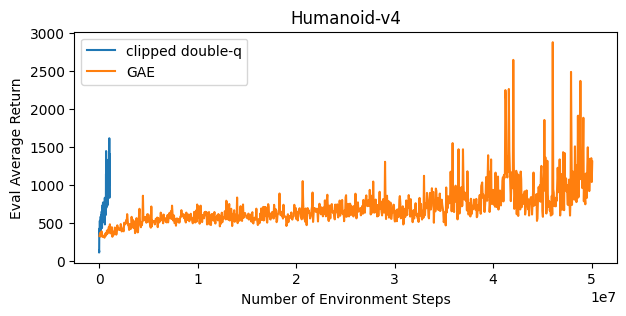

In [8]:
# humanoid.yaml with clipped double-Q

humanoid_clipped_q = extract_tensorboard_scalars('./data/hw3_sac_sac_humanoid_Humanoid-v4_reparametrize_s256_l3_alr0.0003_clr0.0003_b256_d0.99_t0.05_stu0.005_min_16-10-2023_03-05-23/', scalar_keys='eval_return')
humanoid_hw2 = extract_tensorboard_scalars('./data/hw2_humanoid/', scalar_keys='Eval_AverageReturn')
humanoid_hw2_steps = extract_tensorboard_scalars('./data/hw2_humanoid/', scalar_keys='Train_EnvstepsSoFar')

plt.figure(figsize=(7, 3))
plt.plot(humanoid_clipped_q['eval_return']['step'], humanoid_clipped_q['eval_return']['value'], label='clipped double-q')
plt.plot(humanoid_hw2_steps['Train_EnvstepsSoFar']['value'], humanoid_hw2['Eval_AverageReturn']['value'], label='GAE')

plt.title('Humanoid-v4')
plt.xlabel('Number of Environment Steps')
plt.ylabel('Eval Average Return')
plt.legend()
plt.show()